## Start

In [4]:
import torch
torch.cuda.set_device(2)

from rsnautils import *
from fastai2.callback.data import *
# from fastai2.patch_tables import patch_tables
from fastai2.test import *
# patch_tables()

nw = 8

In [5]:
# pre = 'rn18_wgtd_freeze2'
pre = 'rn18_wgtd'

In [6]:
val_sid = df_comb.loc[val_sops].SeriesInstanceUID.unique()

sids = df_comb[df_comb.is_qure==False].SeriesInstanceUID.unique()
idx = L.range(sids)
val_sid = set(list(val_sid))

mask = L(o in val_sid for o in sids)
s_splits = L(idx[~mask],idx[mask])

In [7]:
sz=256

In [8]:
df = df_comb.reset_index().set_index('SeriesInstanceUID').sort_values("ImagePositionPatient2")

In [1]:
class ReadCT:
    def __init__(self,sz):
        self.path = [path_jpg256,path_jpg512][sz is None or sz>256]
        self.rfn = get_pil_fn(self.path)
        self.tt = ToTensor()
    
    def one(self, sop): return self.tt(self.rfn(sop))[:3]
    
    def x(self, sid):
        sids = df.SOPInstanceUID[sid].values
        xs = [self.one(sop) for sop in sids]
        return TensorCTScan(torch.stack(xs))
    
    def y(self, sid): return TensorMultiCategory(df.loc[sid,htypes].values).float()

In [10]:
rct = ReadCT(512)

In [11]:
dsrc = DataSource(sids, [[rct.x],[rct.y]], splits=s_splits)

tensor([[1., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 1., 1.]])

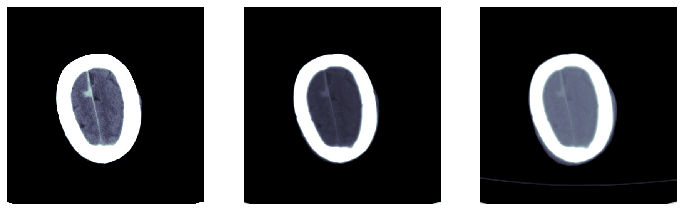

In [13]:
x,y = dsrc.valid[7]
show_images(x[28])
dsrc.valid[7][1][25:30]

In [14]:
mean,std = 0.2,0.3
nrm = Normalize(tensor(mean),tensor(std))
batch_tfms = L(nrm, Cuda(), IntToFloatTensor())
# if with_aug: batch_tfms += aug_transforms(**kwargs)

In [15]:
# if sz is not None:
#     batch_tfms = batch_tfms+[RandomResizedCropGPU(sz, min_scale=0.7, ratio=(1.,1.), valid_scale=0.9)]

In [16]:
dbunch = DataBunch(
    TfmdDL(dsrc.train, bs=None, after_batch=batch_tfms, num_workers=8, shuffle=True),
    TfmdDL(dsrc.valid, bs=None, after_batch=batch_tfms, num_workers=8)
)
dbunch.device = default_device()
dbunch.c = 6

In [17]:
loss_func = get_loss()

In [18]:
class Batchify(Module):
    def forward(self, x): return x[None].transpose(1,2)

class DeBatchify(Module):
    def forward(self, x): return x[0].transpose(0,1)

def conv3(ni,nf,stride=1):
    return ConvLayer(ni, nf, (5,3,3), stride=(1,stride,stride), ndim=3, padding=(2,1,1))

In [19]:
m = nn.Sequential(Batchify(),
    conv3(512,256,2), # 8
    conv3(256,128,2), # 4
    conv3(128, 64,2), # 2
    DeBatchify(), nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(64,6))

init_cnn(m)

In [23]:
# sd = torch.load(f'models/{pre}-3d.pth', map_location='cpu')['model']
# m.load_state_dict(sd)

In [24]:
metrics=[accuracy_multi,accuracy_any,lf2,opt_val_met]
opt_func = partial(Adam, wd=0.0, eps=1e-8, sqr_mom=0.999)

In [25]:
config=dict(custom_head=m, init=None)
learn = cnn_learner(dbunch, resnet18, pretrained=False, loss_func=loss_func, lr=3e-3,# opt_func=opt_func,
                    metrics=metrics, config=config).to_fp16()

In [28]:
# sd = torch.load(f'models/{pre}.pth', map_location='cpu')['model']
# learn.model.load_state_dict(sd, strict=False)

In [29]:
learn.model[-1][-1].bias.data = to_device(logit(avg_lbls))
learn.create_opt()
# learn.freeze()

In [ ]:
learn.fit_one_cycle(1, 1e-3)

In [23]:
learn.save(f'{pre}-e2e')

KeyboardInterrupt: 